In [6]:
# Libraries and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import confusion_matrix
import seaborn as sns

pd.set_option("display.max_rows", None, "display.max_columns", None)
rcParams['figure.figsize'] = 8, 8
plt.style.use('bmh')
plt.style.use('dark_background')

In [7]:
# Load Data
df_mirage = pd.read_csv('H:/cs/train-grenades-de_mirage.csv')
df_inferno = pd.read_csv('H:/cs/train-grenades-de_inferno.csv')

de_mirage_map = plt.imread('H:/cs/de_mirage.png')
de_inferno_map = plt.imread('H:/cs/de_inferno.png')

In [8]:
# changing cords x,y to 0-1024 to match image of the maps
def change_X_Y_coords(df): 
    if df.map_name[0] == 'de_mirage':
        # Min and Max coordinates for de_mirage
        X = [-3217,1912]
        Y = [-3401,1682]
    if df.map_name[0] == 'de_inferno':
         # Min and Max coordinates for de_mirage
        X = [-1960,2797] 
        Y = [-1062,3800]
    # Get size of map    
    size_X = X[1] - X[0] 
    size_Y = Y[1] - Y[0]
    # Size of maps.jpg are 1024x1024
    new_size = 1024 
    # Linear scaling of x coordinations
    df.detonation_raw_x = ((df.detonation_raw_x + abs(X[0]))/size_X*new_size).astype(int)
    df.throw_from_raw_x = ((df.throw_from_raw_x + abs(X[0]))/size_X*new_size).astype(int)
    # Linear scaling of y coordinations
    df.detonation_raw_y = (new_size-((df.detonation_raw_y + abs(Y[0]))/size_Y*new_size)).astype(int)
    df.throw_from_raw_y = (new_size-((df.throw_from_raw_y + abs(Y[0]))/size_Y*new_size)).astype(int)
    return df

In [9]:
df_mirage = change_X_Y_coords(df_mirage)
df_inferno = change_X_Y_coords(df_inferno)


In [10]:
# ploting maps with points of use and detonate of granades by map, place and time
def grenade_map_analyse(df, grenade_type, label, map_type, team, time):
    # Create sub_df with given requirements
    sub_df = df.loc[(df.LABEL==label) & (df.TYPE==grenade_type) & (df.team==team) &
            (df['15_sec_throw']==time),['detonation_raw_x','detonation_raw_y','throw_from_raw_x','throw_from_raw_y']]
    # Plot map.jpg
    plt.imshow(map_type)
    # And scatter plot thrown grenades
    plt.scatter(sub_df.detonation_raw_x,sub_df.detonation_raw_y,zorder=4,alpha=0.6, label='Grenades Detonated')
    plt.scatter(sub_df.throw_from_raw_x,sub_df.throw_from_raw_y,zorder=4,alpha=0.6, label='Grenades Thrown')
    plt.legend()
    team_name = 'Anti Terrorist'
    sentiment = 'Bad'
    if team == 'T':
        team_name = 'Terrorist'
    if label:
        sentiment = 'Good'   
    plt.title(sentiment + ' Thrown of ' + grenade_type + ' grenade by ' + team_name +
              '\n Time from start : ' + str(time*15) + ' - ' + str(time*15+15) + 'sec \n Map: ' + df.map_name[0] )
    plt.ylabel('Y-cords')
    plt.xlabel('X-cords') 
    plt.show()
    del sub_df

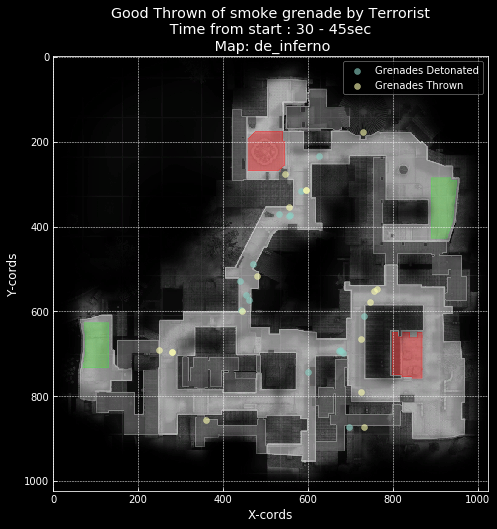

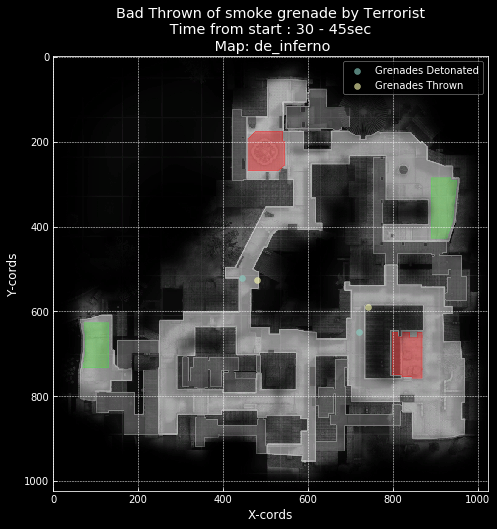

In [11]:
grenade_type = 'smoke' # molotov smoke flashbang
map_type = de_inferno_map # de_mirage_map de_inferno_map 
team = 'T'
label = True
df = df_inferno #df_mirage df_inferno 
time = 2
df['15_sec_throw'] = (df['throw_tick']/128/10).astype(int)
grenade_map_analyse(df, grenade_type, True, map_type, team, time) 
grenade_map_analyse(df, grenade_type, False, map_type, team, time) 

In [12]:
def get_data_balance(df):
    sub_df1 = df.loc[(df.LABEL==False)]
    sub_df2 = df.loc[(df.LABEL==False)]
    sub_df3 = df.loc[(df.LABEL==False)]
    #sub_df4 = df.loc[(df.LABEL==False)]

    sub_df1.loc[:,'throw_tick'] = sub_df1.loc[:,'throw_tick'] + 50
    sub_df1.loc[:,'detonation_tick'] = sub_df1.loc[:,'detonation_tick'] + 50
    sub_df1.loc[:,'throw_from_raw_x'] = sub_df1.loc[:,'throw_from_raw_x'] - 20
    sub_df1.loc[:,'throw_from_raw_y'] = sub_df1.loc[:,'throw_from_raw_y'] - 20  
    
    sub_df2.loc[:,'throw_tick'] = sub_df2.loc[:,'throw_tick'] - 50
    sub_df2.loc[:,'detonation_tick'] = sub_df2.loc[:,'detonation_tick'] - 50
    sub_df2.loc[:,'throw_from_raw_x'] = sub_df2.loc[:,'throw_from_raw_x'] + 20
    sub_df2.loc[:,'throw_from_raw_y'] = sub_df2.loc[:,'throw_from_raw_y'] + 20  
    
    sub_df3.loc[:,'throw_from_raw_x'] = sub_df3.loc[:,'throw_from_raw_x'] - 20
    sub_df3.loc[:,'throw_from_raw_y'] = sub_df3.loc[:,'throw_from_raw_y'] - 20  
    sub_df3.loc[:,'detonation_raw_z'] = sub_df3.loc[:,'detonation_raw_z'] + 25
    sub_df3.loc[:,'detonation_raw_y'] = sub_df3.loc[:,'detonation_raw_y'] + 25 
    sub_df3 = sub_df3[0:-30]
    
    
    df = pd.concat([df,sub_df1,sub_df2,sub_df3])
    return df
def map_coords_to_areas(df,nr_of_areas):
    df.insert(len(df.columns), "Thrown_X_Area",'') 
    df.insert(len(df.columns), "Thrown_Y_Area",'') 
    df.insert(len(df.columns), "Detonated_X_Area",'') 
    df.insert(len(df.columns), "Detonated_Y_Area",'') 
    divider = 1024/nr_of_areas
    for i in range(1,nr_of_areas+1):
        df.loc[(df.throw_from_raw_x>=(i*divider-divider)) & (df.throw_from_raw_x<=(i*divider)),'Thrown_X_Area'] = i
        df.loc[(df.throw_from_raw_y>=(i*divider-divider)) & (df.throw_from_raw_y<=(i*divider)),'Thrown_Y_Area'] = i
        df.loc[(df.detonation_raw_x>=(i*divider-divider)) & (df.detonation_raw_x<=(i*divider)),'Detonated_X_Area'] = i
        df.loc[(df.detonation_raw_y>=(i*divider-divider)) & (df.detonation_raw_y<=(i*divider)),'Detonated_Y_Area'] = i
    return df


In [13]:
df_mirage = map_coords_to_areas(df_mirage,4)
df_inferno = map_coords_to_areas(df_inferno,4)
df = pd.concat([df_mirage,df_inferno])
#df = get_data_balance(df)
df = df.astype({"Thrown_X_Area": int, "Thrown_Y_Area": int,"Detonated_X_Area": int, "Detonated_Y_Area": int})
df['10_sec_throw'] = (df['throw_tick']/128/10).astype(int)

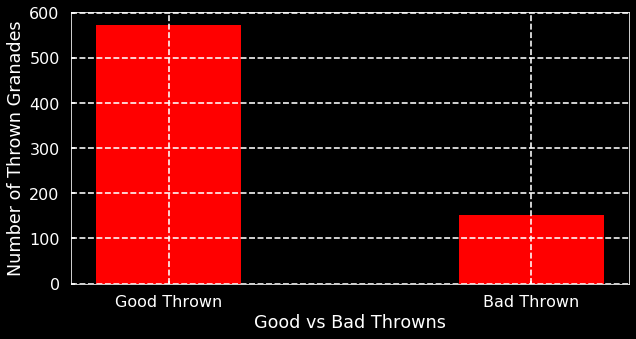

In [14]:
# Check data balance
plt.style.use('seaborn-poster')
data = {'Good Thrown':sum(df.LABEL.astype(int)), 'Bad Thrown':(len(df)-sum(df.LABEL.astype(int)))} 
courses = list(data.keys()) 
values = list(data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
plt.bar(courses, values, color ='red',  
        width = 0.4) 
  
plt.xlabel("Good vs Bad Throwns") 
plt.ylabel("Number of Thrown Granades") 
plt.show() 

In [15]:
# computing deviation of coordinates grouped by team, map, time, and granade type
features_to_groupby = [
    'map_name',
    'team',
    #'LABEL',
    'TYPE',
    '10_sec_throw']

columns_to_get_mean = ['throw_from_raw_x','detonation_raw_x','throw_from_raw_y','detonation_raw_y']
grouped_df = df.groupby(features_to_groupby)
mean_df = grouped_df['throw_from_raw_x','detonation_raw_x','throw_from_raw_y','detonation_raw_y'].mean()
mean_df = mean_df.reset_index()
mean_df.columns = [*mean_df.columns[:-4], 'mean_throw_from_raw_x','mean_detonation_raw_x','mean_throw_from_raw_y','mean_detonation_raw_y']
df = df.merge(mean_df, how = 'inner', on = features_to_groupby)
df.drop_duplicates(keep=False,inplace=True) 
df['throw_dev_x'] = df['throw_from_raw_x'] - df['mean_throw_from_raw_x']
df['throw_dev_y'] = df['throw_from_raw_y'] - df['mean_throw_from_raw_y']
df['detonation_dev_x'] = df['detonation_raw_x'] - df['mean_detonation_raw_x']
df['detonation_dev_y'] = df['detonation_raw_y'] - df['mean_detonation_raw_y']
df = df.reset_index()


C:\Users\Adrian\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [16]:
true_df = df.loc[(df.LABEL==True), ['throw_dev_x','throw_dev_y','detonation_dev_x','detonation_dev_y']]
false_df = df.loc[(df.LABEL==False), ['throw_dev_x','throw_dev_y','detonation_dev_x','detonation_dev_y']]
def get_plot_of_devaition(df,sentiment):
    sent = 'Badly'
    if sentiment:
        sent = "Well"
    plt.scatter(df.detonation_dev_x,df.detonation_dev_y,zorder=4,alpha=0.6, label='Grenades Detonated')
    plt.scatter(df.throw_dev_x,df.throw_dev_y,zorder=4,alpha=0.6, label='Grenades Thrown')
    plt.legend()
    plt.title("Relative Deviation of " +sent+ " Thrown Grenades")
    plt.ylabel('Y-cords')
    plt.xlabel('X-cords')
    plt.show()         

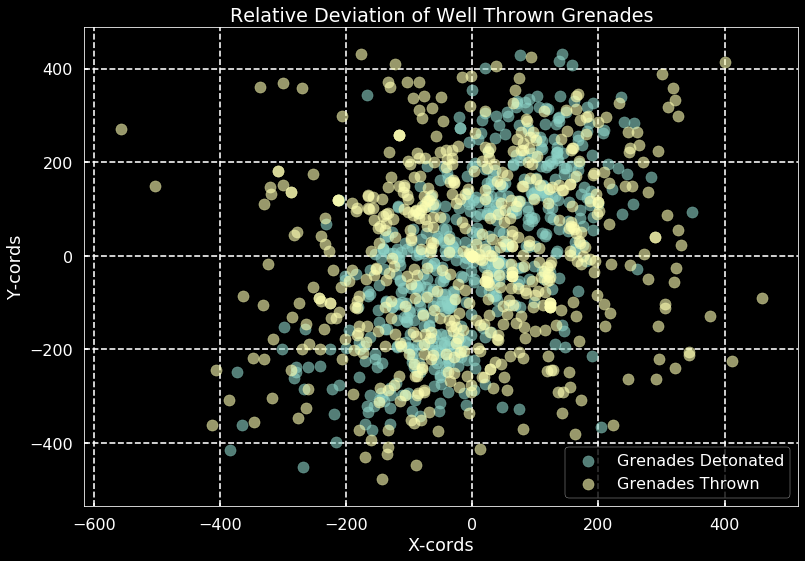

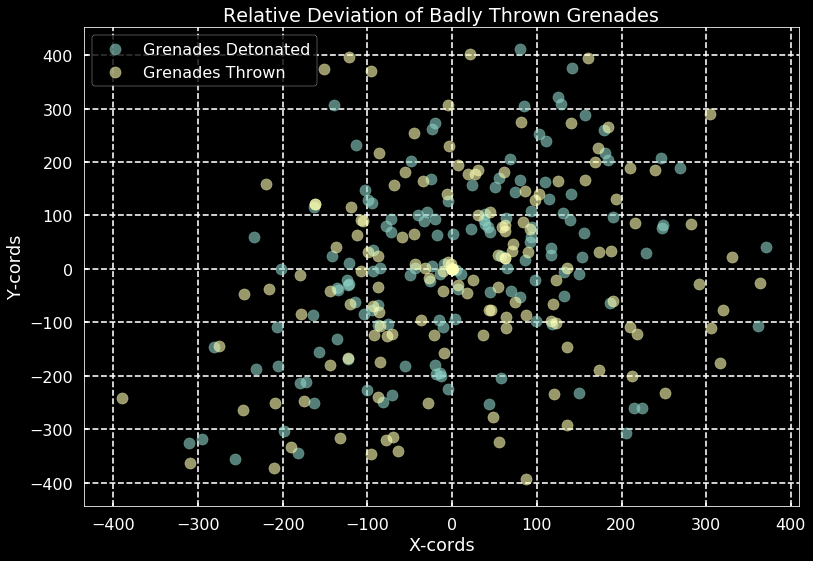

In [17]:

get_plot_of_devaition(true_df,True)
get_plot_of_devaition(false_df,False)


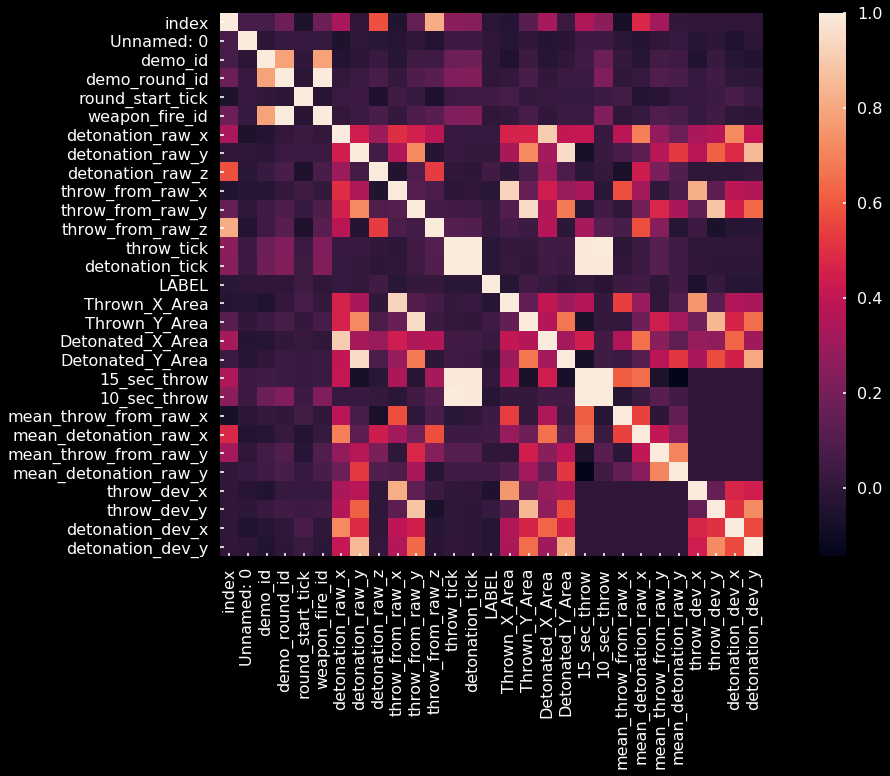

In [21]:
corr = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmax=1, square=True)